# ML engineering workflow
1. import data
extract data from S3
2. pipeline
construct a pipeline for data processing and training
3. model evaluation
4. save model to S3


In [ ]:
# 1. download/extract data from S3
import boto3
import pandas as pd
import io
import os
from dotenv import load_dotenv
load_dotenv()
# Initialize S3 client
s3_client = boto3.client('s3')

BUCKET = os.getenv('CHURN_PREDICTION_BUCKET')
data_key = os.getenv('DATA_KEY', 'data/churn-prediction.csv')

# Get the object
response = s3_client.get_object(Bucket=BUCKET, Key=data_key)

# Read the body of the response
status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

if status == 200:
    # 3. Read bytes into pandas
    csv_string = response["Body"].read()
    df = pd.read_csv(io.BytesIO(csv_string))
    print(df.head())
else:
    print(f"Error fetching file. Status code: {status}")

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [2]:
# 2.0 drop nan rows
from sklearn.model_selection import train_test_split

df = df.drop(labels=df[df['tenure'] == 0].index, axis=0)
df['Churn'] = df['Churn'].replace({'Yes': 1, "No": 0})

X = df.drop(columns = ['Churn'])
y = df['Churn']

# 2.1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X.shape, y.shape

/tmp/ipykernel_117713/1291273259.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'Yes': 1, "No": 0})


((7032, 20), (7032,))

In [3]:
# 2.2 define different columns for pipeline later
cols_to_drop = ['customerID'] # define the columns to be dropped
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols =['PaymentMethod', 'Contract', 'InternetService'] # those that need one-hot encoding
ord_cols = list(set(X.columns)- set(num_cols) - set(cat_cols) - set(cols_to_drop))

In [ ]:
# 2.3 build a pipeline: data processing, train the model
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown="ignore"))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('dropper', 'drop', cols_to_drop),
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
        ("ord", ordinal_transformer, ord_cols)
    ]
)

# Combine preprocessing + model
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, penalty='elasticnet', l1_ratio=0.7, solver='saga'))
])

In [9]:
pipe

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('dropper', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
# X_precessed = pipe.fit_transform(X_train, y_train)
# columns_after_processing = pipe.named_steps["preprocessor"].get_feature_names_out()
# X_precessed_df = pd.DataFrame(X_precessed, columns = columns_after_processing)
# X_precessed_df.head()

In [11]:
# 2.4 use the pipeline to process data and train model
pipe.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('dropper', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:
# 3 use the pipeline to do predict task
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:,1]

In [13]:
# testing, output metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    mean_squared_error, r2_score, silhouette_score, roc_curve
)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print(f"acc: {acc}, prec: {prec}, rec: {rec}, f1: {f1}, auc: {auc}, ")
print(classification_report(y_test, y_pred))

acc: 0.8038379530916845, prec: 0.6484848484848484, rec: 0.5721925133689839, f1: 0.6079545454545454, auc: 0.8362577716116808, 
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



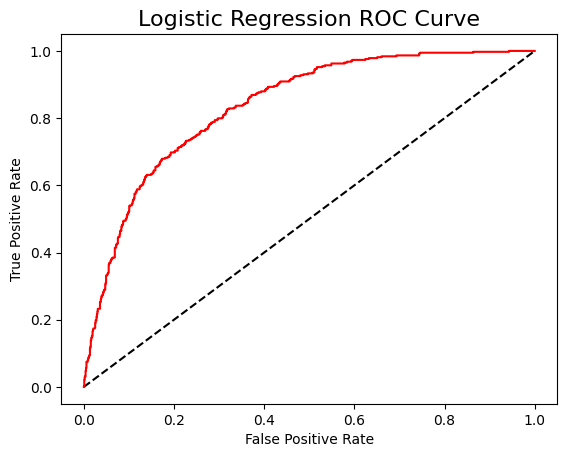

In [14]:
# 3. testing, plot ROC Curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr, tpr, label='Logistic Regression',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve',fontsize=16)
plt.show();

In [ ]:
# 4. upload pipeline to S3
import joblib
import boto3
from io import BytesIO

# .Serialize and Upload to S3
model_key = 'models/churn_prediction_pipeline.joblib'

# Save to a buffer and upload directly
with BytesIO() as f:
    # joblib.dump(pipe, f)
    joblib.dump(pipe, f, protocol=4)
    f.seek(0)
    boto3.client('s3').upload_fileobj(f, BUCKET, model_key)

print(f"Model saved to s3://{BUCKET}/{model_key}")